# 集成学习 Ensemble Learning
1. 基本思想：将多个预测效果一般的弱学习器（基学习器）组合起来，构成一个预测效果优良的强学习器。
2. 因为数据+算法=结果，故监督学习要想得到不同估计结果，只能给定数据并使用不同的算法，或者给定算法使用不同的数据。
   - 不同算法+相同数据：使用不同算法，将所得结果加权平均，通过交叉验证确定权重
   - 不同数据+相同算法：给定算法，然后选取不同数据，得到不同的决策树模型，如装袋法和随机森林。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,StratifiedKFold
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error,cohen_kappa_score,plot_roc_curve
from mlxtend.plotting import plot_decision_regions
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.inspection import plot_partial_dependence

# 一、装袋法 Bagging
使用自助法来获取不同数据。
对于回归树，B棵树的预测结果为：$$\hat f_{bag}(x)=\frac{1}{B}\sum_{b=1}^{B}\hat f^{*b}(x)$$
对于分类树，B棵树的预测结果为：$$\hat f_{bag}(x)=\underset{y\in{1,\cdots,K}}{argmin}\quad\sum_{b=1}^{B}I(\hat f^{*b}(x)=y)$$
优点：
1. 装袋法将很多决策树的预测值平均，故可降低方差（参考X均值的方差）。
2. Bagging不对决策树的叶子节点数目进行惩罚，故可降低偏差。
3. 装袋法适用于方差较大的不稳定估计量，比如决策树、线性回归的变量子集选择等。
4. 单棵决策树为分段常值函数，故并不连续，而Bagging将血多决策树平均，则可以得到更为光滑的回归曲线或决策边界，从而提高预测性能。

缺点：
1. 不适用于方差较小的稳定估计量，如KNN估计量。
2. 无法保证每个决策树之间不相关，也就无法保证方差的缩小力度，事实上同一全样本相同算法相同特征变量的决策树之间往往相关。

袋外均方误差：
每棵决策树均存在袋外观测值，可作为测试集，对于任意观测值$x_i$，它未出现于大约B/3的决策树中，将这些决策树的预测结果进行平均，即可得到第$i$个观测值的袋外预测值$\hat y_{i,OOB}$，进一步得到袋外误差。

对于回归问题：$$MSE_{OOB}=\frac{1}{n}\sum_{i=1}^n(\hat y_{i,OOB}-y_i)^2$$

对于分类问题：$$MSE_{OOB}=\frac{1}{n}\sum_{i=1}^nI(\hat y_{i,OOB}\neq y_i)$$

In [2]:
data=pd.read_csv('/Users/singal/Desktop/MLPython_Data/mcycle.csv')
data

,times,accel
0,2.4,0.0
1,2.6,-1.3
2,3.2,-2.7
3,3.6,0.0
4,4.0,-2.7
...,...,...
128,53.2,-14.7
129,55.0,-2.7
130,55.0,10.7
131,55.4,-2.7


## 1、单棵决策树预测结果

In [3]:
x=np.array(data.times).reshape(-1,1)
y=data.accel
model=DecisionTreeRegressor(random_state=123)
ccp_path=model.cost_complexity_pruning_path(x,y)
param_grid={'ccp_alpha':ccp_path.ccp_alphas}
kfold=KFold(n_splits=10,random_state=1,shuffle=True)
model=GridSearchCV(DecisionTreeRegressor(random_state=123),cv=kfold,param_grid=param_grid)
model.fit(x,y)
pred=model.predict(x)

Text(0.5, 1.0, 'Single Tree Estimation')

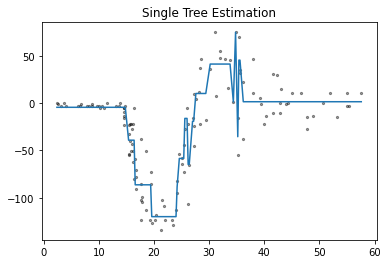

In [4]:
plt.plot(x,pred)
plt.scatter(x,y,c='k',s=5,alpha=0.4)
plt.title('Single Tree Estimation')

## 2、装袋法估计结果

In [5]:
model=BaggingRegressor(base_estimator=DecisionTreeRegressor(random_state=123),n_estimators=500,random_state=0)
pred=model.fit(x,y).predict(x)

Text(0.5, 1.0, 'Bagging Estimation')

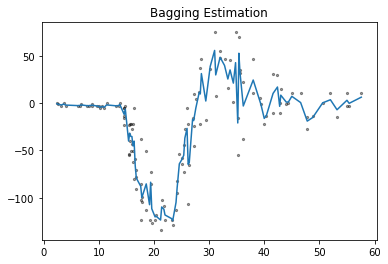

In [6]:
plt.scatter(x,y,c='k',s=5,alpha=0.4)
plt.plot(x,pred)
plt.title('Bagging Estimation')

## 3、结论
从两张预测图可看出，单决策树所估计的回归函数呈阶梯形，与矩阵类似，并不连续，拟合效果不好；而装袋法所估计的回归函数虽然不太光滑，但相比单决策树有明显改善，拟合效果更好。
# 二、回归问题的随机森林
1. 随机特征选择（列子抽样）：在决策树的每个节点进行分裂时，仅随机选择部分变量（建议mtry=p/3）作为候选的分裂变量，以降低相关性。
2. 随机森林以牺牲少量偏差为代价，换取方差的大幅下降，从而降低MSE。
3. mtry很小，则欠拟合；mtry很大，则过拟合。
4. 随机森林的B不重要，增加B不会导致过拟合。

## 1、数据处理

In [7]:
data=load_boston()
x=pd.DataFrame(data=data.data,columns=data.feature_names)
y=data.target
xtrain,xtest,ytrain,ytest=train_test_split(x,y,random_state=1,test_size=0.3)#不用shuffle

## 2、基于回归树的装袋法

In [8]:
model=BaggingRegressor(base_estimator=DecisionTreeRegressor(random_state=123),n_estimators=500,oob_score=True,random_state=0)
model.fit(xtrain,ytrain)

BaggingRegressor(base_estimator=DecisionTreeRegressor(random_state=123),
                 n_estimators=500, oob_score=True, random_state=0)

In [9]:
pred_oob=model.oob_prediction_
mean_squared_error(ytrain,pred_oob)#袋外均方误差

11.323470116238905

In [10]:
model.oob_score_#袋外预测值的拟合优度

0.8605296124474909

In [11]:
model.score(xtest,ytest)#测试集拟合优度

0.9054552734857662

In [12]:
model=LinearRegression().fit(xtrain,ytrain)#使用线性回归的拟合优度
model.score(xtest,ytest)

0.7836295385076284

结果显示，基于回归树的装袋法，其测试集拟合优度明显高于线性回归。

选择最优参数——自助样本数目B。

In [13]:
oob_errors=[]
for n_estimator in range(100,301):
    model=BaggingRegressor(base_estimator=DecisionTreeRegressor(random_state=123),n_estimators=n_estimator,random_state=0,oob_score=True,n_jobs=-1)
    model.fit(xtrain,ytrain)
    pred_oob=model.oob_prediction_
    oob_errors.append(mean_squared_error(ytrain,pred_oob))

Text(0, 0.5, 'OOB MSE')

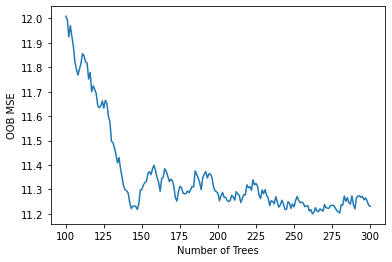

In [14]:
plt.plot(range(100,301),oob_errors)
plt.xlabel('Number of Trees')
plt.ylabel('OOB MSE')

当B>200时，袋外误差已基本稳定下来。
## 3、回归问题的随机森林估计

In [15]:
model=RandomForestRegressor(n_estimators=500,max_features=int(xtrain.shape[1]/3),random_state=0)#max_features为int类型则表示个数，为float类型则表示比例
model.fit(xtrain,ytrain)
model.score(xtrain,ytrain),model.score(xtest,ytest)

(0.9800645261374809, 0.8959042792611034)

Text(0, 0.5, 'Y_prediction')

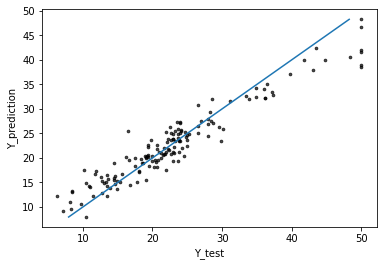

In [16]:
pred=model.predict(xtest)
plt.scatter(ytest,pred,c='k',alpha=0.7,s=7)
w=np.linspace(min(pred),max(pred),100)
plt.plot(w,w)
plt.xlabel('Y_test')
plt.ylabel('Y_prediction')

由图可见，随机森林预测值与实际值的散点较为密切地围绕在45度线附近，表明取得了较好的预测效果。

变量重要性：

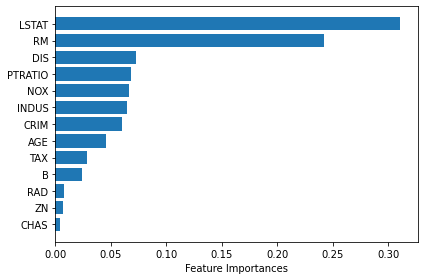

In [17]:
index=np.argsort(model.feature_importances_)
plt.barh(range(x.shape[1]),model.feature_importances_[index])
plt.yticks(range(x.shape[1]),labels=data.feature_names[index])
plt.xlabel('Feature Importances')
plt.tight_layout()

偏依赖图：

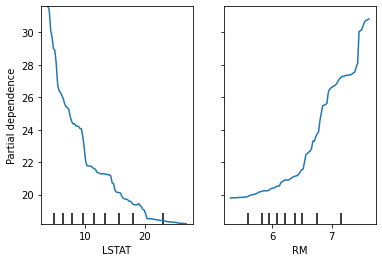

In [18]:
plot_partial_dependence(model,x,features=['LSTAT','RM'])

变量RM对房价有着正向的影响作用，且并非线性，在RM较小的尾部区域，对响应变量的影响微弱。

通过测试集选择最优参数mtry：

In [19]:
scores=[]
for i in range(1,x.shape[1]+1):
    model=RandomForestRegressor(max_features=i,n_estimators=500,random_state=123)
    model.fit(xtrain,ytrain)
    scores.append(model.score(xtest,ytest))

In [20]:
index=np.argmax(scores)
range(1,x.shape[1]+1)[index]

9

Text(0, 0.5, 'R2')

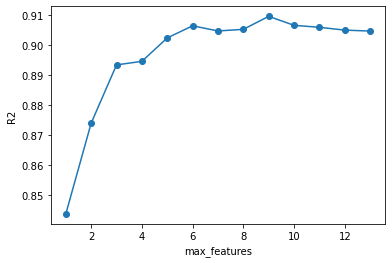

In [21]:
plt.plot(range(1,x.shape[1]+1),scores,'o-')
plt.xlabel('max_features')
plt.ylabel('R2')

GridSearchCV默认评分标准为score

In [22]:
param_grid={'max_features':range(1,x.shape[1]+1)}
kfold=KFold(n_splits=10,shuffle=True,random_state=1)
model=GridSearchCV(RandomForestRegressor(n_estimators=300,random_state=123),param_grid=param_grid,cv=kfold,return_train_score=True,n_jobs=-1,scoring='neg_mean_squared_error')
model.fit(xtrain,ytrain)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=RandomForestRegressor(n_estimators=300,
                                             random_state=123),
             n_jobs=-1, param_grid={'max_features': range(1, 14)},
             return_train_score=True, scoring='neg_mean_squared_error')

In [23]:
model.best_params_

{'max_features': 5}

cv_results_每个split的输出格式为(1,n)，n表示参数网格中所包含的参数个数。

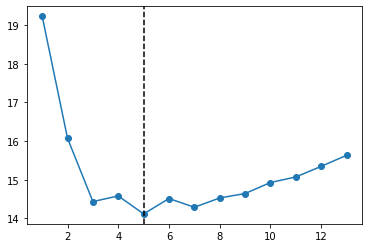

In [24]:
cv_mse=-model.cv_results_['mean_test_score']
plt.plot(range(1,x.shape[1]+1),cv_mse,'o-')
plt.axvline(model.best_params_['max_features'],linestyle='--',color='k')

# 三、分类问题的随机森林
## 1、数据处理

In [25]:
data=pd.read_csv('/Users/singal/Desktop/MLPython_Data/Sonar.csv')
data.shape

(208, 61)

In [26]:
data.head(5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V52,V53,V54,V55,V56,V57,V58,V59,V60,Class
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [27]:
data.Class.value_counts()

M    111
R     97
Name: Class, dtype: int64

In [28]:
X=data.iloc[:,:-1]
y=data.iloc[:,-1]

观察相关系数图：

<AxesSubplot:>

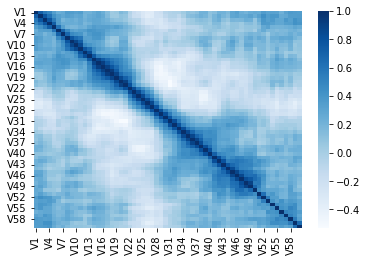

In [29]:
sns.heatmap(X.corr(),cmap="Blues")#颜色越深，相关系数越大

In [30]:
xtrain,xtest,ytrain,ytest=train_test_split(X,y,random_state=1,stratify=y,test_size=50)

## 2、逻辑回归、分类树、随机森林的比较

In [31]:
model=DecisionTreeClassifier(random_state=123)
path=model.cost_complexity_pruning_path(xtrain,ytrain)
param_grid={'ccp_alpha':path.ccp_alphas}
kfold=KFold(n_splits=10,random_state=1,shuffle=True)
model=GridSearchCV(DecisionTreeClassifier(random_state=123),param_grid,cv=kfold)
model.fit(xtrain,ytrain)
model.score(xtest,ytest)

0.78

In [32]:
model=LogisticRegression(C=1e10,max_iter=500).fit(xtrain,ytrain)
model.score(xtest,ytest)

0.7

In [33]:
model=RandomForestClassifier(n_estimators=500,max_features='sqrt',random_state=123)
model.fit(xtrain,ytrain)
model.score(xtest,ytest)

0.78

结果显示，随机森林的预测准确率高于单棵决策树和逻辑回归的准确率。
## 3、选择最优参数mtry

In [34]:
param_grid={'max_features':range(1,X.shape[1]+1)}
kfold=StratifiedKFold(n_splits=10,random_state=1,shuffle=True)
model=GridSearchCV(RandomForestClassifier(n_estimators=500,random_state=123),param_grid=param_grid,cv=kfold,n_jobs=-1)

In [35]:
model.fit(xtrain,ytrain)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
             estimator=RandomForestClassifier(n_estimators=500,
                                              random_state=123),
             n_jobs=-1, param_grid={'max_features': range(1, 61)})

In [36]:
model.best_params_,model.score(xtest,ytest)

({'max_features': 9}, 0.82)

In [37]:
model=model.best_estimator_

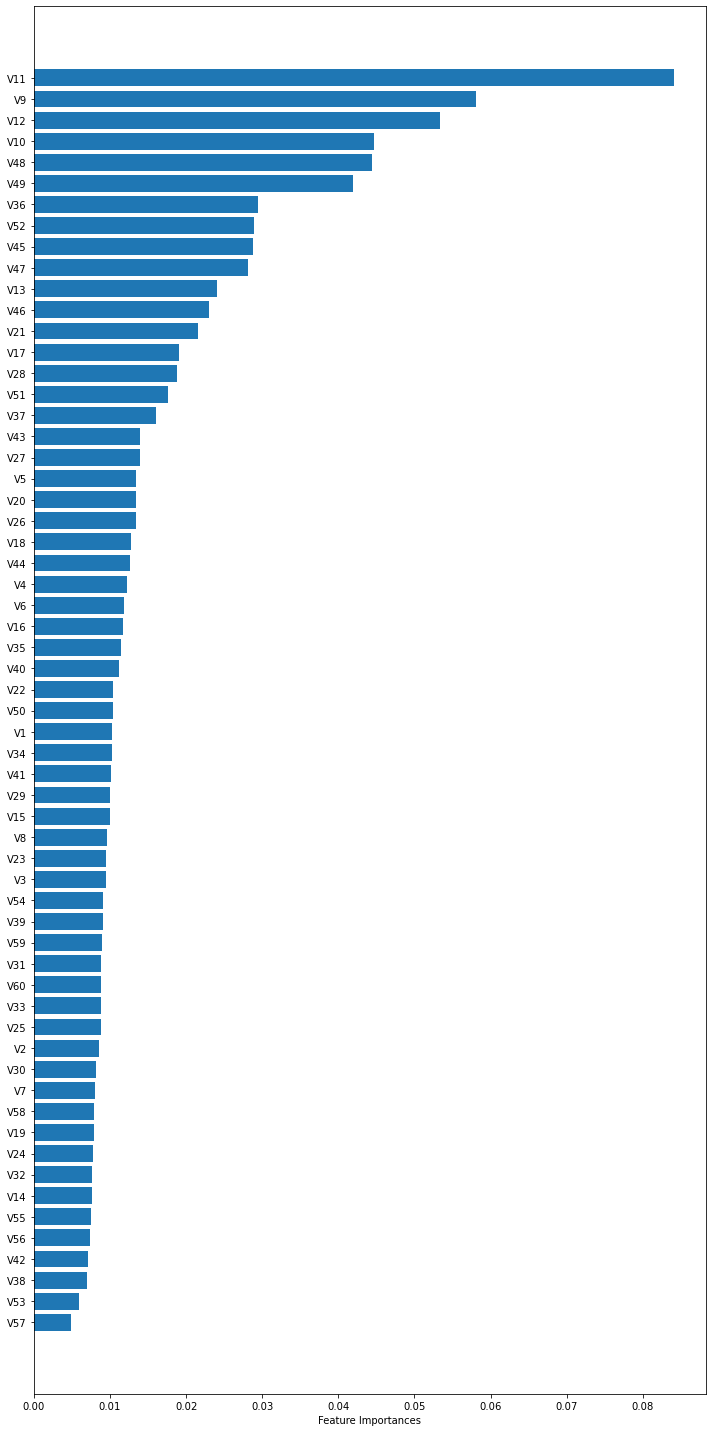

In [38]:
index=np.argsort(model.feature_importances_)
plt.figure(figsize=(10,20))
plt.barh(range(X.shape[1]),model.feature_importances_[index])
plt.yticks(range(X.shape[1]),X.columns[index])
plt.xlabel('Feature Importances')
plt.tight_layout()

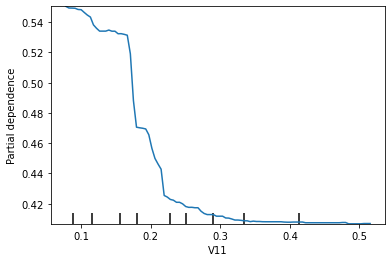

In [39]:
plot_partial_dependence(model,xtrain,['V11'])

混淆矩阵：

In [40]:
pred=model.predict(xtest)
tab=pd.crosstab(ytest,pred,colnames=['Predicted'],rownames=['Actual'])
tab

Predicted,M,R
Actual,,
M,22,5
R,4,19


In [41]:
accuracy=(22+19)/(22+5+4+19)
sensitivity=19/(4+19)
specificity=22/(22+5)
accuracy,sensitivity,specificity,cohen_kappa_score(ytest,pred)

(0.82, 0.8260869565217391, 0.8148148148148148, 0.6388443017656501)

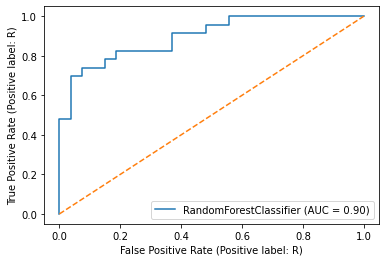

In [42]:
plot_roc_curve(model,xtest,ytest)
w=np.linspace(0,1,100)
plt.plot(w,w,'--')